# Import Packages

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import utils
from sklearn.metrics import mean_squared_error
import numpy as np


# Import Sales Data

- We do not import the data of 2021 so that we get the same data again when we execute the notebook in the future.


- For this approach, we just need Week, Year, Site_ID, SKU, Sales_QTY

In [2]:
query = 'SELECT Week, Year, Site_ID, SKU, Sales_QTY FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year <= 2020 order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:00:34.077068
Mem. usage decreased to 42.74 Mb (67.5% reduction)


In [3]:
df = df_raw.copy()
df

,Week,Year,Site_ID,SKU,Sales_QTY
0,26,2010,101,2069466,1.0
1,27,2010,101,2069466,0.0
2,28,2010,101,2069466,1.0
3,29,2010,101,2069466,6.0
4,30,2010,101,2069466,0.0
...,...,...,...,...,...
3447542,53,2020,101,1290002601,0.0
3447543,50,2020,116,1290002601,1.0
3447544,51,2020,116,1290002601,0.0
3447545,52,2020,116,1290002601,0.0


In [4]:
# Concatenate Week and Year to simplify code implementation
df.loc[:, 'Date'] = ((df.Year).astype(str) + df.Week.astype(str)).astype(int)

# Time Series Cross Validation

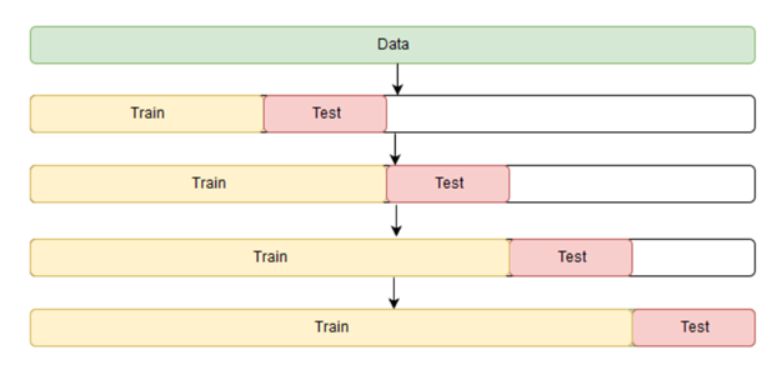

# Naive Forecasts (Forecasts = last observed value)

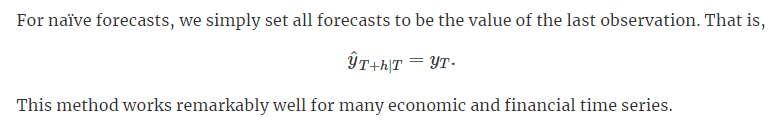

Add new column with lagged values representing the sales numbers of the previous week.

In [5]:
df.loc[:, 'Sales_Preview_Week'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(1))
df

,Week,Year,Site_ID,SKU,Sales_QTY,Date,Sales_Preview_Week
0,26,2010,101,2069466,1.0,201026,NaN
1,27,2010,101,2069466,0.0,201027,1.0
2,28,2010,101,2069466,1.0,201028,0.0
3,29,2010,101,2069466,6.0,201029,1.0
4,30,2010,101,2069466,0.0,201030,6.0
...,...,...,...,...,...,...,...
3447542,53,2020,101,1290002601,0.0,202053,0.0
3447543,50,2020,116,1290002601,1.0,202050,NaN
3447544,51,2020,116,1290002601,0.0,202051,1.0
3447545,52,2020,116,1290002601,0.0,202052,0.0


In [6]:
rmse = []

splits = utils.get_splits(df, fh=1, n_splits=12)

for week, year in splits:
    y_pred = df.loc[df.Date == int(
        f'{year}{week+1}')].Sales_Preview_Week.fillna(0)
    y_test = df.loc[df.Date == int(f'{year}{week+1}')].Sales_QTY

    rmse.append(mean_squared_error(y_test, y_pred, squared=False))

print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [0.6332877, 0.65770346, 0.6386567, 0.5987777, 0.70675063, 0.6344398, 0.4783156, 0.52874786, 0.59178036, 0.51464784, 0.5274074, 0.64992326]

Crossvalidated RMSE:  0.59670323
